# A notebook for measuring the number of infected cells over time

In [1]:
import napari
from cellpose import models
from macrohet import dataio, tile
import numpy as np
import os

def view(img):
    return napari.Viewer().add_image(img)

from napari_animation import Animation
from tqdm.auto import tqdm

import btrack
import dask.array as da

from skimage.transform import rescale, resize, downscale_local_mean

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks")
sns.set_palette("Spectral")

from macrohet import tools, visualise

### Load all metadata

Both the image metadata and the assay layout metadata

In [2]:
base_dir = '/mnt/DATA/macrohet/'
# base_dir = '/Volumes/lab-gutierrezm/home/users/dayn/macrohet/'
metadata_fn = os.path.join(base_dir, 'macrohet_images/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0303K1F1P1R1,Ok,r03c03f01p01-ch1sk1fk1fl1.tiff,3,3,1,1,0,1,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1,0303K1F1P1R2,Ok,r03c03f01p01-ch2sk1fk1fl1.tiff,3,3,1,1,0,2,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
2,0303K1F1P2R1,Ok,r03c03f01p02-ch1sk1fk1fl1.tiff,3,3,1,2,0,1,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3,0303K1F1P2R2,Ok,r03c03f01p02-ch2sk1fk1fl1.tiff,3,3,1,2,0,2,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
4,0303K1F1P3R1,Ok,r03c03f01p03-ch1sk1fk1fl1.tiff,3,3,1,3,0,1,1,...,4E-06,0.135587499,0,2021-04-16T19:09:34.4+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,0609K75F9P1R2,Ok,r06c09f09p01-ch2sk75fk1fl1.tiff,6,9,9,1,74,2,1,...,0,0.135533601,266399.61,2021-04-19T21:14:19.477+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113396,0609K75F9P2R1,Ok,r06c09f09p02-ch1sk75fk1fl1.tiff,6,9,9,2,74,1,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113397,0609K75F9P2R2,Ok,r06c09f09p02-ch2sk75fk1fl1.tiff,6,9,9,2,74,2,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113398,0609K75F9P3R1,Ok,r06c09f09p03-ch1sk75fk1fl1.tiff,6,9,9,3,74,1,1,...,4E-06,0.135537595,266399.61,2021-04-19T21:14:20.037+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [3]:
metadata_path = os.path.join(base_dir, 'macrohet_images/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

# Iteratively load all tracks

and append to a track_dict dictionary

In [4]:
tracks_dict = dict()
### iterate over all experimental conditions
for (row, column), info in tqdm(assay_layout.iterrows(), 
                                desc = 'Progress through positions',
                                total = len(assay_layout)):

    ### load tracks
    with btrack.io.HDF5FileHandler(os.path.join(base_dir, 
                                                f'labels/macrohet_seg_model/{row,column}.h5'), 
                                       'r', 
                                       obj_type='obj_type_1'
                                       ) as reader:
        tracks = reader.tracks
            
    ### append tracks to dictionary
    tracks_dict[(row, column)] = tracks

Progress through positions:   0%|          | 0/24 [00:00<?, ?it/s]

[INFO][2023/06/07 10:20:51 AM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 4).h5...
[INFO][2023/06/07 10:20:51 AM] Loading tracks/obj_type_1
[INFO][2023/06/07 10:20:51 AM] Loading LBEP/obj_type_1
[INFO][2023/06/07 10:20:51 AM] Loading objects/obj_type_1 (39878, 5) (39878 filtered: None)
[INFO][2023/06/07 10:20:52 AM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 4).h5
[INFO][2023/06/07 10:20:52 AM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5...
[INFO][2023/06/07 10:20:52 AM] Loading tracks/obj_type_1
[INFO][2023/06/07 10:20:52 AM] Loading LBEP/obj_type_1
[INFO][2023/06/07 10:20:52 AM] Loading objects/obj_type_1 (41424, 5) (41424 filtered: None)
[INFO][2023/06/07 10:20:52 AM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5
[INFO][2023/06/07 10:20:52 AM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 6).h5...
[INFO][2023/06/07 10:20:52 AM] Loading tracks/obj_type_1
[INFO]

[INFO][2023/06/07 10:21:09 AM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5
[INFO][2023/06/07 10:21:09 AM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 6).h5...
[INFO][2023/06/07 10:21:09 AM] Loading tracks/obj_type_1
[INFO][2023/06/07 10:21:09 AM] Loading LBEP/obj_type_1
[INFO][2023/06/07 10:21:09 AM] Loading objects/obj_type_1 (45688, 5) (45688 filtered: None)
[INFO][2023/06/07 10:21:10 AM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 6).h5
[INFO][2023/06/07 10:21:10 AM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 7).h5...
[INFO][2023/06/07 10:21:10 AM] Loading tracks/obj_type_1
[INFO][2023/06/07 10:21:10 AM] Loading LBEP/obj_type_1
[INFO][2023/06/07 10:21:10 AM] Loading objects/obj_type_1 (45214, 5) (45214 filtered: None)
[INFO][2023/06/07 10:21:11 AM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 7).h5
[INFO][2023/06/07 10:21:11 AM] Opening HDF file: /mnt/DATA/macrohe

# Compile all longer length tracks into dataframe

Add extra information such as the MSD of cells between frames

In [ ]:
### list of track info dfs
dfs = list()
### empty dictionary for filtered tracks
filtered_tracks = dict()
### iterate over all tracks
for key in tqdm(tracks_dict.keys()):
    ### extract tracks only with max length
    filtered_tracks[key] = [track for track in tracks_dict[key] if len(track) >40] #== 75]
    ### iterate over full length tracks
    for track in filtered_tracks[key]:
        ### get info for assay layout
        info = assay_layout.loc[key]
        ### mtb values (remove nan by linear interpolation)
        mtb_values = pd.Series(track['mean_intensity'][:, 2]).interpolate(method='linear')
        ### smooth mtb signal by using a rolling window of 4 with median values then backfill the missing values at the start
        mtb_smooth = np.array(mtb_values.rolling(window=4).median().interpolate(method='backfill',))
        ### compile single track dictionary of info
        d = {'Time (hours)':track['t'], 
             'x':track['x'],
             'y':track['y'],
             'x scaled':[track['x'][i]*5.04 for i, x in enumerate(track['x'])],
             'y scaled':[track['y'][i]*5.04 for i, y in enumerate(track['y'])],
             'Infection status':track['Infected'],
             'Initial infection status':track['Infected'][0], 
             'Final infection status':track['Infected'][-1], 
             'Area':track['area'], 
             'Intracellular mean Mtb content':track['mean_intensity'][:, 1],
             'Intracellular thresholded Mtb content':mtb_values,
             'Intracellular thresholded Mtb content smooth':mtb_smooth,
             'Macroph. GFP expression':track['mean_intensity'][:, 0],
             # calculates the total change over all time
             'delta Mtb raw': [np.array(mtb_values)[-1] - np.array(mtb_values)[0] 
                               for i in range(len(track))],
             # calculates the maximum change over all time and calibrates it as an increase or decrease
             'delta Mtb max raw': [(max(mtb_values) - min(mtb_values)) * (1 if np.argmax(mtb_values) > np.argmin(mtb_values) else -1) for i in range(len(track))],
             # calcaultes the same as above but for smooth values
             'delta Mtb max smooth': [(max(mtb_smooth) - min(mtb_smooth)) * (1 if np.argmax(mtb_smooth) > np.argmin(mtb_smooth) else -1) for i in range(len(track))],
             ### this one calculate the fold change of the minimum non zero value (indicating the cell is infected)
             'delta Mtb max fold-change': [max(mtb_smooth) / min(mtb_smooth[mtb_smooth>0]) * (1 if np.argmax(mtb_smooth) > np.argmin(mtb_smooth) else -1) if np.any(mtb_smooth>0) else 0 for i in range(len(track)) ],
             'delta Mtb max fold-change normalised mean area': [(max(mtb_smooth) / min(mtb_smooth[mtb_smooth>0]) * (1 if np.argmax(mtb_smooth) > np.argmin(mtb_smooth) else -1))/np.mean(track['area']) if np.any(mtb_smooth>0) else 0 for i in range(len(track)) ],
             'delta Mtb max fold-change normalised max area': [(max(mtb_smooth) / min(mtb_smooth[mtb_smooth>0]) * (1 if np.argmax(mtb_smooth) > np.argmin(mtb_smooth) else -1))/np.max(track['area']) if np.any(mtb_smooth>0) else 0 for i in range(len(track)) ],
             'delta Mtb/dt': np.polyfit(np.arange(len(mtb_smooth)), mtb_smooth, 1)[0],
             'Eccentricity':np.sqrt(1-((track['minor_axis_length']**2)/(track['major_axis_length']**2))),
             'MSD': [tools.euc_dist(track['x'][i-1], 
                                    track['y'][i-1], 
                                    track['x'][i], 
                                    track['y'][i]) 
                      if i != 0 else 0
                      for i in range(0, len(track))],
             'Strain':[info['Strain'] for i in range(len(track['t']))], 
             'Compound':[info['Compound'] for i in range(len(track['t']))], 
             'Concentration':[info['ConcentrationEC'] for i in range(len(track['t']))], 
             'Cell ID':[track.ID for i in range(len(track['t']))],
             'Acquisition ID':[key for i in range(len(track['t']))], 
             'Unique ID': [f'{track.ID}.{key[0]}.{key[1]}' for i in range(len(track['t']))]}
        ### append df to list of dfs
        dfs.append(pd.DataFrame(d))
### concat single track dfs into big df
df = pd.concat(dfs, ignore_index=True)
df

  0%|          | 0/24 [00:00<?, ?it/s]

# Style

In [31]:
sns.set(font='Nimbus Sans', style = 'white')

### Old style

In [54]:
sns.color_palette('PiYG')

[(0.8129181084198386, 0.2544405997693195, 0.5693194925028835),
 (0.9348712033833141, 0.6798154555940021, 0.8312187620146096),
 (0.9856978085351787, 0.9031910803537101, 0.9458669742406767),
 (0.9202614379084968, 0.9629373317954633, 0.8576701268742792),
 (0.6908881199538641, 0.8624375240292197, 0.4883506343713959),
 (0.38269896193771624, 0.6403690888119954, 0.18108419838523643)]

In [55]:
colors = ['#013220',#'#008B8B',#(0.204*0.8, 0.330*0.8, 0.706*0.8), 
          sns.color_palette('PiYG')[0], sns.color_palette('PiYG')[-1]]
colors

['#013220',
 (0.8129181084198386, 0.2544405997693195, 0.5693194925028835),
 (0.38269896193771624, 0.6403690888119954, 0.18108419838523643)]

### New style

In [64]:
import importlib

In [65]:
importlib.reload(visualise)

<module 'macrohet.visualise' from '/home/dayn/analysis/macrohet/macrohet/visualise.py'>

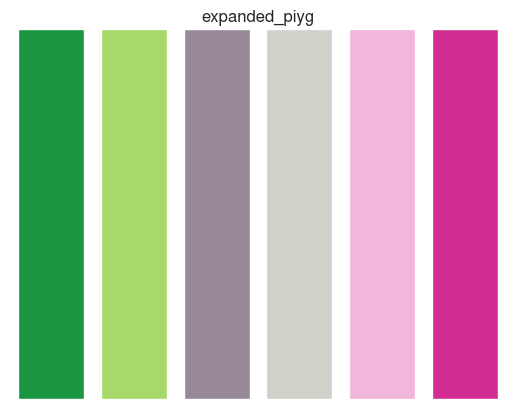

['#1a9641', '#a6d96a', '#978897', '#d1d1ca', '#f1b6da', '#d02c91']


In [71]:


# Get the color palette of the PiYG color map
expanded_piyg = visualise.color_palette('expanded_piyg').colors

sns.set_palette(expanded_piyg)

# Display the colors in the PiYG color map
visualise.show_colors('expanded_piyg')
print(expanded_piyg)


# Output

In [83]:
output_dir = '/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/thresholded_480_jun23/'
os.makedirs(output_dir, exist_ok = True)

# What proportion of cells are positive?

In [40]:
N_cell_dict = dict()
N_cell_df = list()
for acq_ID in df['Acquisition ID'].unique():
    expt_df = df[df['Acquisition ID'] == acq_ID]
    N_cells = list()
    N_cells_infected = list()
    N_cells_uninfected = list()
    N_cell_dict[acq_ID] = dict()
    info = assay_layout.loc[acq_ID]
    for t in range(0, 75):
        N_cells.append(len(expt_df[expt_df['Time (hours)'] == t]))
        N_cells_infected.append(len(expt_df[(expt_df['Time (hours)'] == t) 
                                            & (expt_df['Infection status'] == 1)]))
        N_cells_uninfected.append(len(expt_df[(expt_df['Time (hours)'] == t) 
                                            & (expt_df['Infection status'] != 1)]))
        
    d = {'Time (hours)':list(range(0, 75)), 
         'N_cells':N_cells,
         'N_cells_infected':N_cells_infected,
         'N_cells_uninfected':N_cells_uninfected, 
         'Acquisition ID': [acq_ID for i in range(0,75)],
         'Strain':[info['Strain'] for i in range(0, 75)], 
         'Compound':[info['Compound'] for i in range(0, 75)], 
         'Concentration':[info['ConcentrationEC'] for i in  range(0, 75)], }
    N_cell_df.append(pd.DataFrame(d))
### concat single track dfs into big df
N_cell_df = pd.concat(N_cell_df, ignore_index=True)
N_cell_df

,Time (hours),N_cells,N_cells_infected,N_cells_uninfected,Acquisition ID,Strain,Compound,Concentration
0,0,259,118,141,"(3, 4)",RD1,CTRL,EC0
1,1,280,126,154,"(3, 4)",RD1,CTRL,EC0
2,2,283,116,167,"(3, 4)",RD1,CTRL,EC0
3,3,289,118,171,"(3, 4)",RD1,CTRL,EC0
4,4,295,120,175,"(3, 4)",RD1,CTRL,EC0
...,...,...,...,...,...,...,...,...
1795,70,197,130,67,"(6, 9)",WT,BDQ,EC99
1796,71,194,130,64,"(6, 9)",WT,BDQ,EC99
1797,72,185,121,64,"(6, 9)",WT,BDQ,EC99
1798,73,179,124,55,"(6, 9)",WT,BDQ,EC99


In [90]:
N_cell_df['N_cells_infected_percentage'] = N_cell_df.apply(lambda row: (row['N_cells_infected'] / row['N_cells'])*100, axis=1)


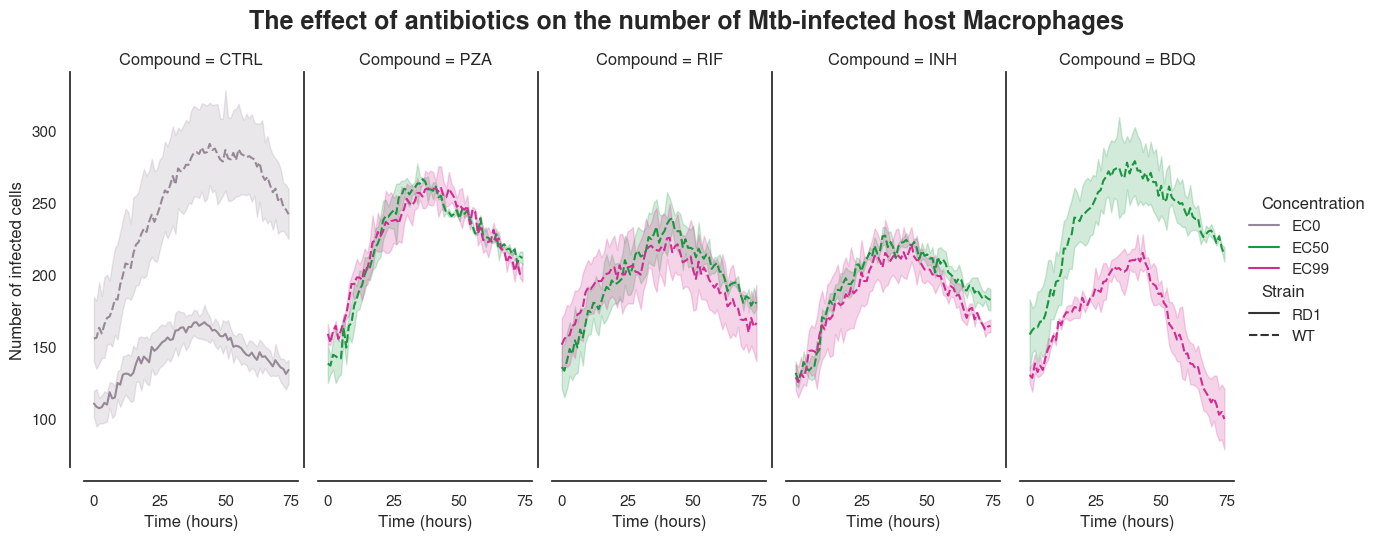

In [85]:
g = sns.relplot(data = N_cell_df,
                x = 'Time (hours)', 
                y = 'N_cells_infected', 
                style= 'Strain',
                hue= 'Concentration',
                col= 'Compound',
                kind = 'line',
                aspect = 0.5,
            palette=[ expanded_piyg[2], expanded_piyg[0],  expanded_piyg[-1],]
           )
# # f.set_ylabels("Intracellular $\\mathit{Mtb}$ content")
# g.set_ylabels("Intracellular Mtb content")
g.set_ylabels("Number of infected cells")
# # Italicize the "Mtb" portion of the y-axis label using the font manager
# g.ax.yaxis.label.set_fontstyle("italic")
# # plt.rc('text', usetex=False)
# plt.gcf().suptitle('The effect of Bedaquiline EC50 on wild-type \nMtb proliferation within host Macrophages', 
#                    fontsize=14, fontweight='bold', 
#                   y = 1.08)
sns.despine(offset=10)
plt.gcf().suptitle('The effect of antibiotics on the number of Mtb-infected host Macrophages', 
                   fontsize=18, fontweight='bold', 
                  y = 1.05)
plt.savefig(os.path.join(output_dir, 'N_cells_infected.png'), bbox_inches = 'tight', dpi = 314)

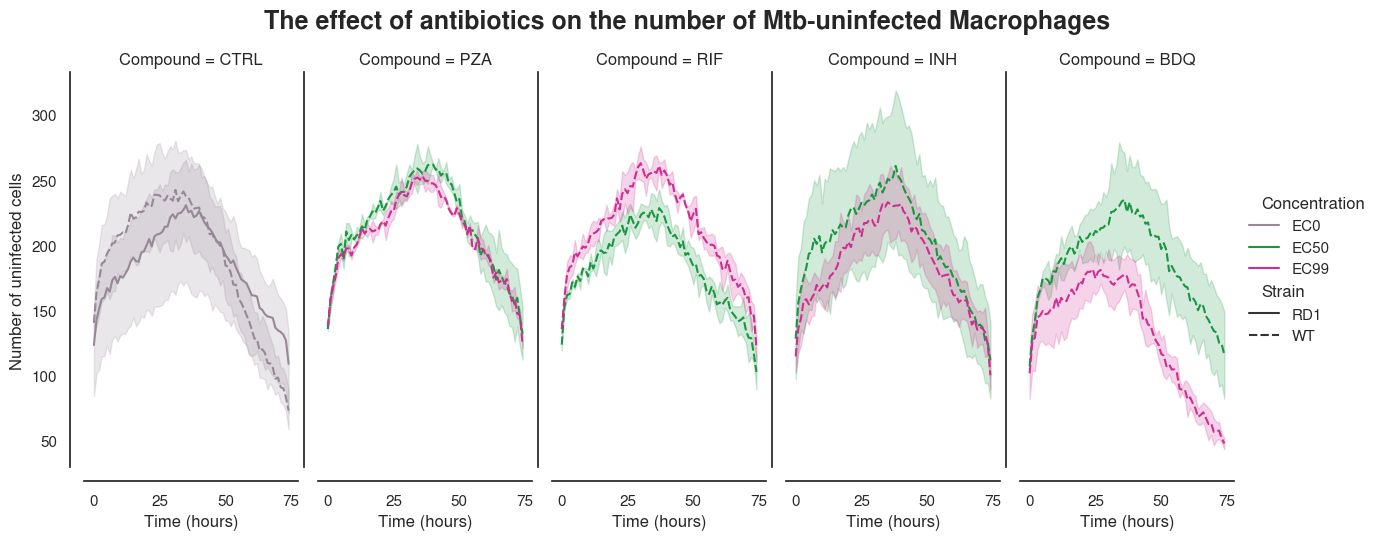

In [86]:
g = sns.relplot(data = N_cell_df,
                x = 'Time (hours)', 
                y = 'N_cells_uninfected', 
                style= 'Strain',
                hue= 'Concentration',
                col= 'Compound',
                kind = 'line',
                aspect = 0.5,
            palette=[ expanded_piyg[2], expanded_piyg[0],  expanded_piyg[-1],]
           )
g.set_ylabels("Number of uninfected cells")
sns.despine(offset=10)
plt.gcf().suptitle('The effect of antibiotics on the number of Mtb-uninfected Macrophages', 
                   fontsize=18, fontweight='bold', 
                  y = 1.05)
plt.savefig(os.path.join(output_dir, 'N_cells_uninfected.png'), bbox_inches = 'tight', dpi = 314)

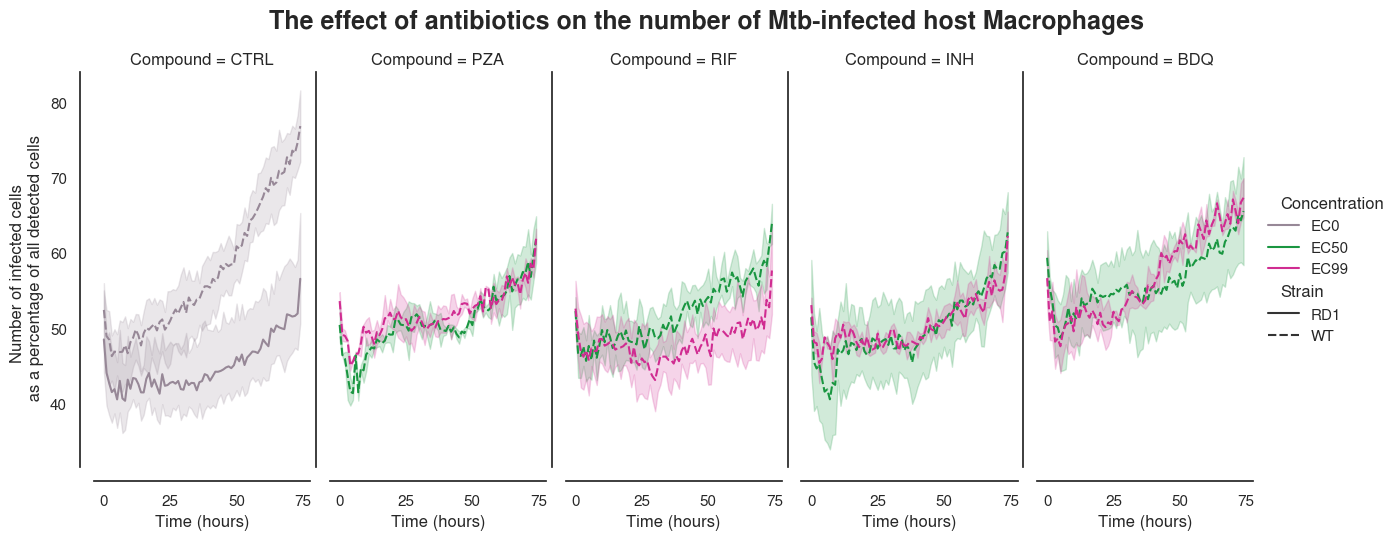

In [93]:
g = sns.relplot(data = N_cell_df,
                x = 'Time (hours)', 
                y = 'N_cells_infected_percentage', 
                style= 'Strain',
                hue= 'Concentration',
                col= 'Compound',
                kind = 'line',
                aspect = 0.5,
            palette=[ expanded_piyg[2], expanded_piyg[0],  expanded_piyg[-1],]
           )
# # f.set_ylabels("Intracellular $\\mathit{Mtb}$ content")
# g.set_ylabels("Intracellular Mtb content")
g.set_ylabels("Number of infected cells \n as a percentage of all detected cells")
# # Italicize the "Mtb" portion of the y-axis label using the font manager
# g.ax.yaxis.label.set_fontstyle("italic")
# # plt.rc('text', usetex=False)
# plt.gcf().suptitle('The effect of Bedaquiline EC50 on wild-type \nMtb proliferation within host Macrophages', 
#                    fontsize=14, fontweight='bold', 
#                   y = 1.08)
sns.despine(offset=10)
plt.gcf().suptitle('The effect of antibiotics on the number of Mtb-infected host Macrophages', 
                   fontsize=18, fontweight='bold', 
                  y = 1.05)
plt.savefig(os.path.join(output_dir, 'N_cells_infected_percentage.png'), bbox_inches = 'tight', dpi = 314)

# Effect of ATB on WT

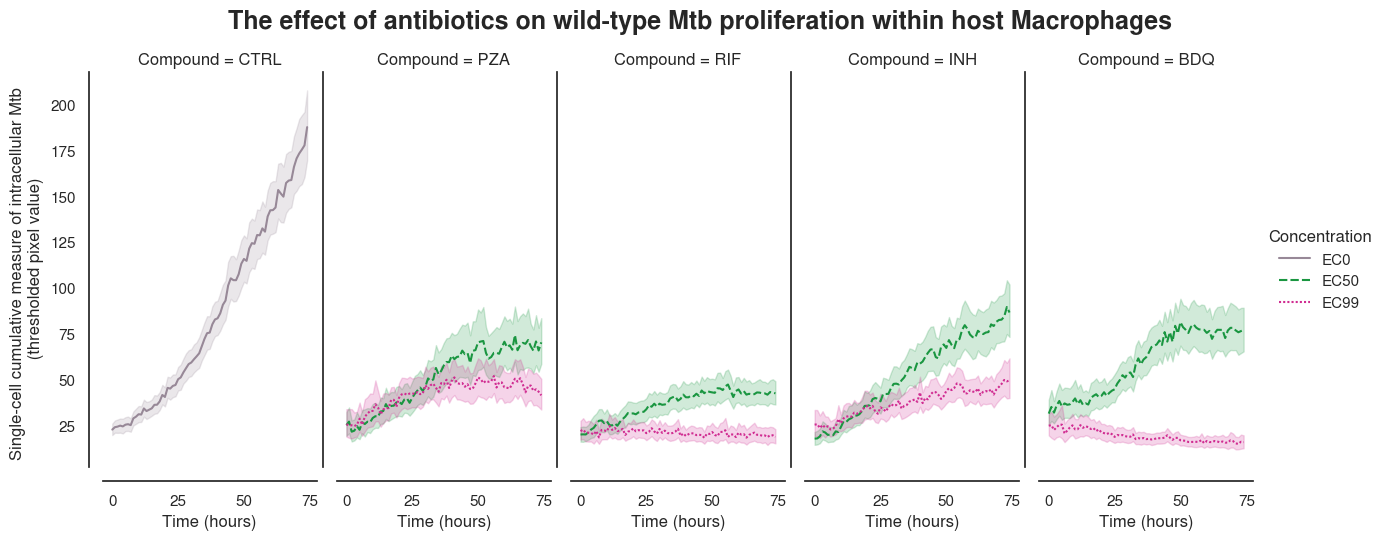

In [77]:
g = sns.relplot(data = df[df['Strain'] != 'RD1'], 
            x = 'Time (hours)', 
            y = 'Intracellular thresholded Mtb content', 
            hue = 'Concentration', 
            style = 'Concentration',
            col= 'Compound',
            kind = 'line',
            aspect = 0.5,
            palette=[ expanded_piyg[2], expanded_piyg[0],  expanded_piyg[-1],]
           )
# # g.set_ylabels("Intracellular Mtb content")
# g.set_ylabels("Intracellular $\\mathit{Mycobacterium tuberculosis}$")
# plt.gcf().suptitle('The effect of antibiotics on wild-type **$\\mathit{Mycobacterium tuberculosis}$** (Mtb) proliferation within host Macrophages', 
#                    fontsize=14, fontweight='bold', 
#                   y = 1.05)
# plt.rc('text', usetex=False)
# g.set_ylabels("Intracellular Mtb content")
g.set_ylabels("Single-cell cumulative measure of intracellular Mtb \n (thresholded pixel value)")
plt.gcf().suptitle('The effect of antibiotics on wild-type Mtb proliferation within host Macrophages', 
                   fontsize=18, fontweight='bold', 
                  y = 1.05)
plt.rc('text', usetex=False)
sns.despine(offset = 10)
plt.savefig(os.path.join(output_dir, 'ATB_effect_WT_Mtb.png'), bbox_inches = 'tight', dpi = 314)

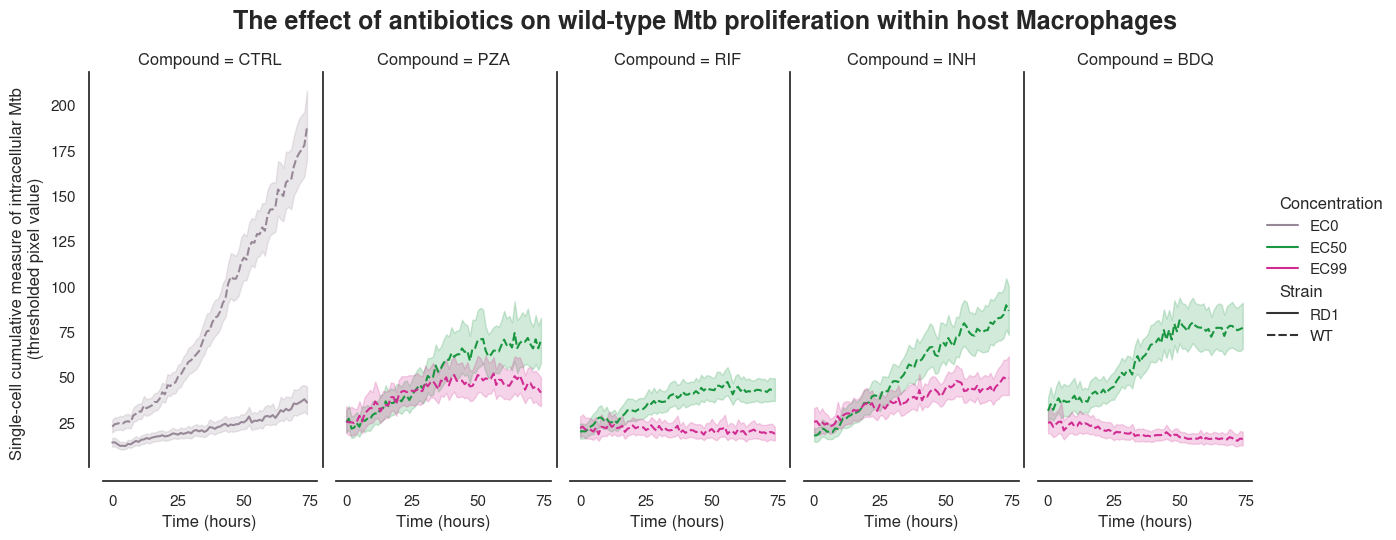

In [78]:
g = sns.relplot(data = df, 
            x = 'Time (hours)', 
            y = 'Intracellular thresholded Mtb content', 
            hue = 'Concentration', 
            style = 'Strain',
            col= 'Compound',
            kind = 'line',
            aspect = 0.5,
            palette=[ expanded_piyg[2], expanded_piyg[0],  expanded_piyg[-1],]
           )
# # g.set_ylabels("Intracellular Mtb content")
# g.set_ylabels("Intracellular $\\mathit{Mycobacterium tuberculosis}$")
# plt.gcf().suptitle('The effect of antibiotics on wild-type **$\\mathit{Mycobacterium tuberculosis}$** (Mtb) proliferation within host Macrophages', 
#                    fontsize=14, fontweight='bold', 
#                   y = 1.05)
# plt.rc('text', usetex=False)
# g.set_ylabels("Intracellular Mtb content")
g.set_ylabels("Single-cell cumulative measure of intracellular Mtb \n (thresholded pixel value)")
plt.gcf().suptitle('The effect of antibiotics on wild-type Mtb proliferation within host Macrophages', 
                   fontsize=18, fontweight='bold', 
                  y = 1.05)
plt.rc('text', usetex=False)
sns.despine(offset = 10)
plt.savefig(os.path.join(output_dir, 'ATB_effect_Mtb.png'), bbox_inches = 'tight', dpi = 314)

# How many cells are truly permissive ie deltaMtb>0

#### What do the different distributions of deltaMtb look like?

In [416]:
df_delta_mtb = df.drop_duplicates(subset=['delta Mtb raw', 'delta Mtb max raw','delta Mtb max smooth', 'delta Mtb max fold-change'])
df_delta_mtb

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,delta Mtb max fold-change normalised max area,delta Mtb/dt,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID
0,0,708.125061,77.589088,3568.950308,391.049006,0.0,0.0,1.0,42556.0,365.408905,...,NaN,0.418707,0.813310,0.0,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
42,0,261.683105,4.945100,1318.882852,24.923306,0.0,0.0,0.0,6754.0,355.006958,...,NaN,-0.142246,0.913146,0.0,RD1,CTRL,EC0,424,"(3, 4)",424.3.4
89,0,349.589508,8.074520,1761.931121,40.695581,0.0,0.0,0.0,13672.0,344.202454,...,0.000000,0.000000,0.957093,0.0,RD1,CTRL,EC0,425,"(3, 4)",425.3.4
152,0,457.172943,8.791715,2304.151633,44.310242,1.0,1.0,0.0,20542.0,343.157196,...,NaN,0.346945,0.929721,0.0,RD1,CTRL,EC0,426,"(3, 4)",426.3.4
226,0,663.630920,10.924337,3344.699839,55.058660,0.0,0.0,0.0,20098.0,353.067780,...,NaN,0.031179,0.805467,0.0,RD1,CTRL,EC0,427,"(3, 4)",427.3.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701271,33,660.136597,577.060730,3327.088447,2908.386079,0.0,0.0,0.0,47448.0,377.264587,...,NaN,-0.000397,0.952213,0.0,WT,BDQ,EC99,2297,"(6, 9)",2297.6.9
701313,33,224.372467,131.369995,1130.837234,662.104775,1.0,1.0,1.0,98867.0,373.245178,...,NaN,0.050624,0.885194,0.0,WT,BDQ,EC99,2292,"(6, 9)",2292.6.9
701355,33,1106.007935,1032.619019,5574.279990,5204.399854,0.0,0.0,1.0,53641.0,366.914032,...,NaN,0.366863,0.950100,0.0,WT,BDQ,EC99,2286,"(6, 9)",2286.6.9
701397,34,477.689026,538.676697,2407.552690,2714.930552,0.0,0.0,0.0,36503.0,356.196930,...,0.000167,0.374870,0.796381,0.0,WT,BDQ,EC99,2324,"(6, 9)",2324.6.9


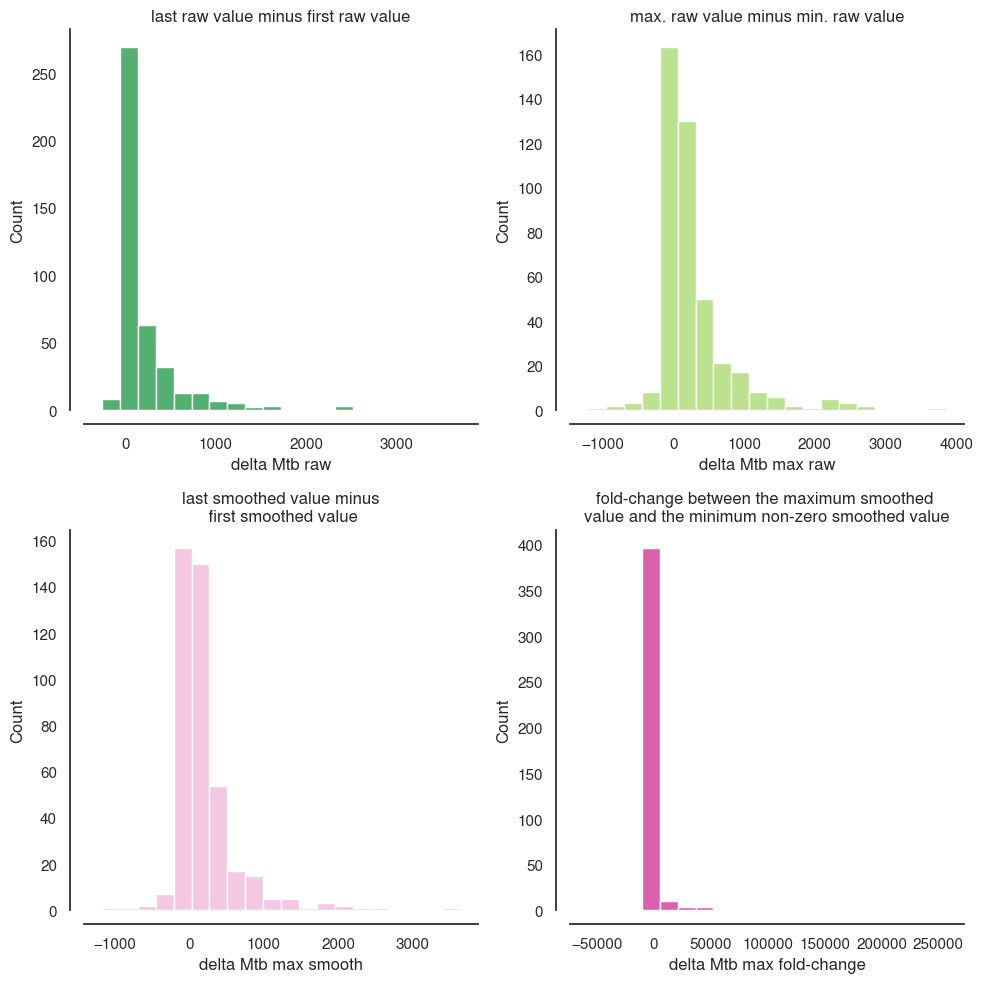

In [389]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.histplot(data=df_delta_mtb[df_delta_mtb['Acquisition ID']==(3,5)], x='delta Mtb raw', kde=False, ax=axes[0, 0], bins = 20, color=expanded_piyg[0])
axes[0, 0].set_title('last raw value minus first raw value')
# axes[0, 0].set_ylim([0, 300])  # set the ylim for the first subplot

sns.histplot(data=df_delta_mtb[df_delta_mtb['Acquisition ID']==(3,5)], x='delta Mtb max raw', kde=False, ax=axes[0, 1], bins = 20, color=expanded_piyg[1])
axes[0, 1].set_title('max. raw value minus min. raw value')
# axes[0, 1].set_ylim([0, 300])  # set the ylim for the second subplot

sns.histplot(data=df_delta_mtb[df_delta_mtb['Acquisition ID']==(3,5)], x='delta Mtb max smooth', kde=False, ax=axes[1, 0], bins = 20, color=expanded_piyg[-2])
axes[1, 0].set_title('last smoothed value minus\n first smoothed value')
# axes[1, 0].set_ylim([0, 300])  # set the ylim for the third subplot

sns.histplot(data=df_delta_mtb[df_delta_mtb['Acquisition ID']==(3,5)], x='delta Mtb max fold-change', kde=False, ax=axes[1, 1], bins = 20, color=expanded_piyg[-1])
axes[1, 1].set_title('fold-change between the maximum smoothed \nvalue and the minimum non-zero smoothed value')
# axes[1, 1].set_ylim([0, 100])  # set the ylim for the fourth subplot

sns.despine(offset=10)

plt.tight_layout()

plt.savefig(os.path.join(output_dir, 'single-cell_signal/delta_mtb_considerations/delta_mtb_approach_hist_unclipped_3,5.png'), 
           bbox_inches = 'tight', dpi = 314)

plt.show() 


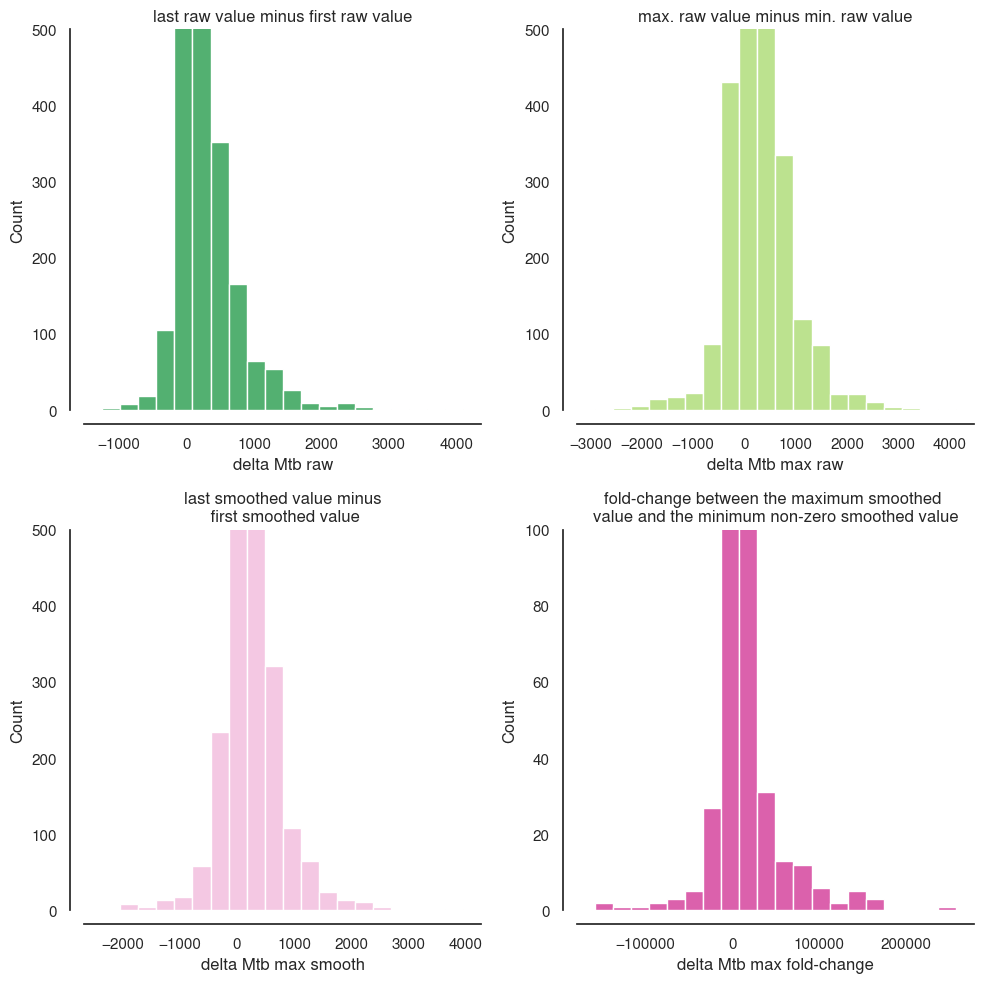

In [384]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.histplot(data=df_delta_mtb, x='delta Mtb raw', kde=False, ax=axes[0, 0], bins = 20, color=expanded_piyg[0])
axes[0, 0].set_title('last raw value minus first raw value')
axes[0, 0].set_ylim([0, 500])  # set the ylim for the first subplot

sns.histplot(data=df_delta_mtb, x='delta Mtb max raw', kde=False, ax=axes[0, 1], bins = 20, color=expanded_piyg[1])
axes[0, 1].set_title('max. raw value minus min. raw value')
axes[0, 1].set_ylim([0, 500])  # set the ylim for the second subplot

sns.histplot(data=df_delta_mtb, x='delta Mtb max smooth', kde=False, ax=axes[1, 0], bins = 20, color=expanded_piyg[-2])
axes[1, 0].set_title('last smoothed value minus\n first smoothed value')
axes[1, 0].set_ylim([0, 500])  # set the ylim for the third subplot

sns.histplot(data=df_delta_mtb, x='delta Mtb max fold-change', kde=False, ax=axes[1, 1], bins = 20, color=expanded_piyg[-1])
axes[1, 1].set_title('fold-change between the maximum smoothed \nvalue and the minimum non-zero smoothed value')
axes[1, 1].set_ylim([0, 100])  # set the ylim for the fourth subplot

sns.despine(offset=10)

plt.tight_layout()

plt.savefig(os.path.join(output_dir, 'single-cell_signal/delta_mtb_considerations/delta_mtb_approach_hist_clipped.png'), 
           bbox_inches = 'tight', dpi = 314)

plt.show() 


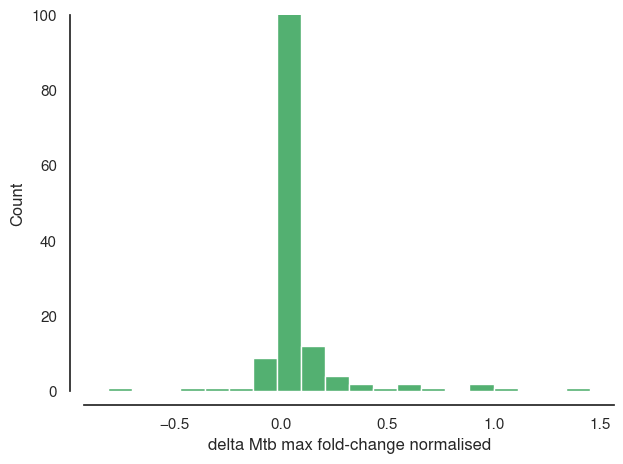

In [414]:

sns.histplot(data=df_delta_mtb, x='delta Mtb max fold-change normalised', kde=False, bins = 20, color=expanded_piyg[0])
sns.despine(offset=10)
plt.ylim(0,100)
plt.tight_layout()

plt.savefig(os.path.join(output_dir, 'single-cell_signal/delta_mtb_considerations/delta_mtb_norm_hist_clipped.png'), 
           bbox_inches = 'tight', dpi = 314)

plt.show() 

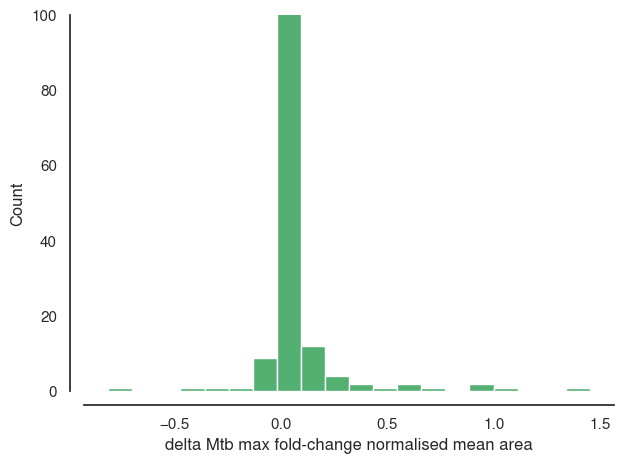

In [431]:
sns.histplot(data=df_delta_mtb, x='delta Mtb max fold-change normalised mean area', kde=False, bins = 20, color=expanded_piyg[0])
sns.despine(offset=10)
plt.ylim(0,100)
plt.tight_layout()

plt.savefig(os.path.join(output_dir, 'single-cell_signal/delta_mtb_considerations/delta_mtb_norm_hist_clipped.png'), 
           bbox_inches = 'tight', dpi = 314)

plt.show() 

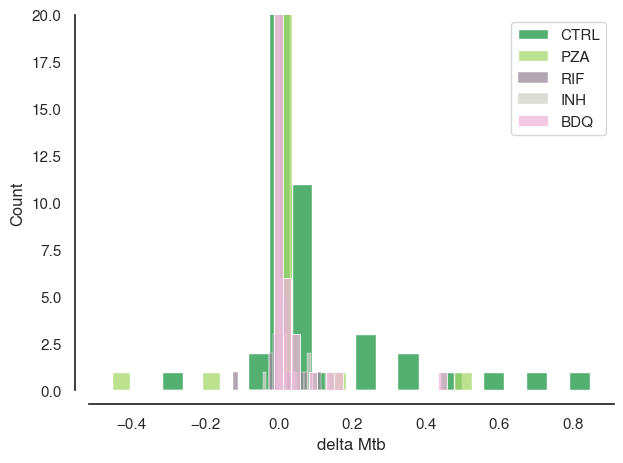

In [439]:
for i, compound in enumerate(df_delta_mtb['Compound'].unique()):
    subset = df_delta_mtb[df_delta_mtb['Compound'] == compound]
    sns.histplot(data=subset, x='delta Mtb max fold-change normalised max area', label = compound, kde=False, bins = 20, color=expanded_piyg[i])
sns.despine(offset=10)
plt.ylim(0,20)
plt.tight_layout()


plt.xlabel('delta Mtb')
plt.legend()
# plt.xlim(-10000,10000)

# plt.savefig(os.path.join(output_dir, 'single-cell_signal/delta_mtb_considerations/delta_mtb_norm_hist_clipped.png'), 
#            bbox_inches = 'tight', dpi = 314)
plt.show() 

# Going with fold-change

In [402]:
num_zero_entries = (df_delta_mtb['delta Mtb max fold-change'] == 0).sum()
print(num_zero_entries)

766


In [424]:
expanded_piyg

['#1a9641', '#a6d96a', '#978897', '#d1d1ca', '#f1b6da', '#d02c91']

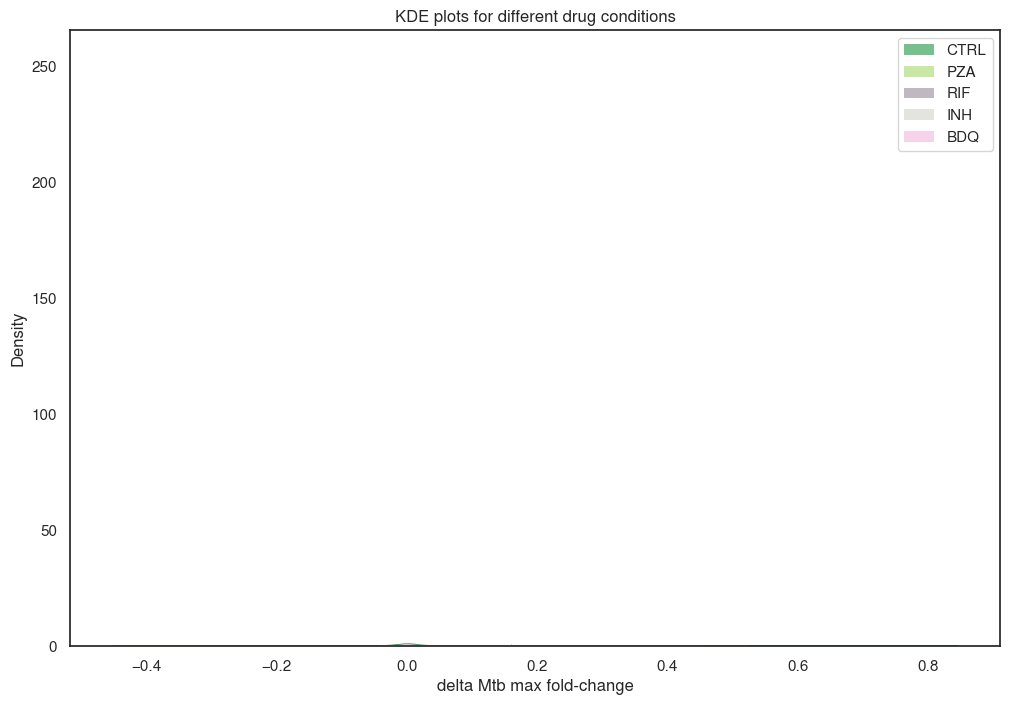

In [441]:
plt.figure(figsize=(12, 8))
for i, compound in enumerate(df_delta_mtb['Compound'].unique()):
    subset = df_delta_mtb[df_delta_mtb['Compound'] == compound]
    sns.histplot(data=subset, x='delta Mtb max fold-change normalised max area', label = compound,
                 kde=True, color=expanded_piyg[i], alpha = 0.6)

plt.xlabel('delta Mtb max fold-change')
plt.ylabel('Density')
plt.title('KDE plots for different drug conditions')
plt.legend()
# plt.xlim(-10000,10000)
# plt.ylim(0, 150)
plt.show()

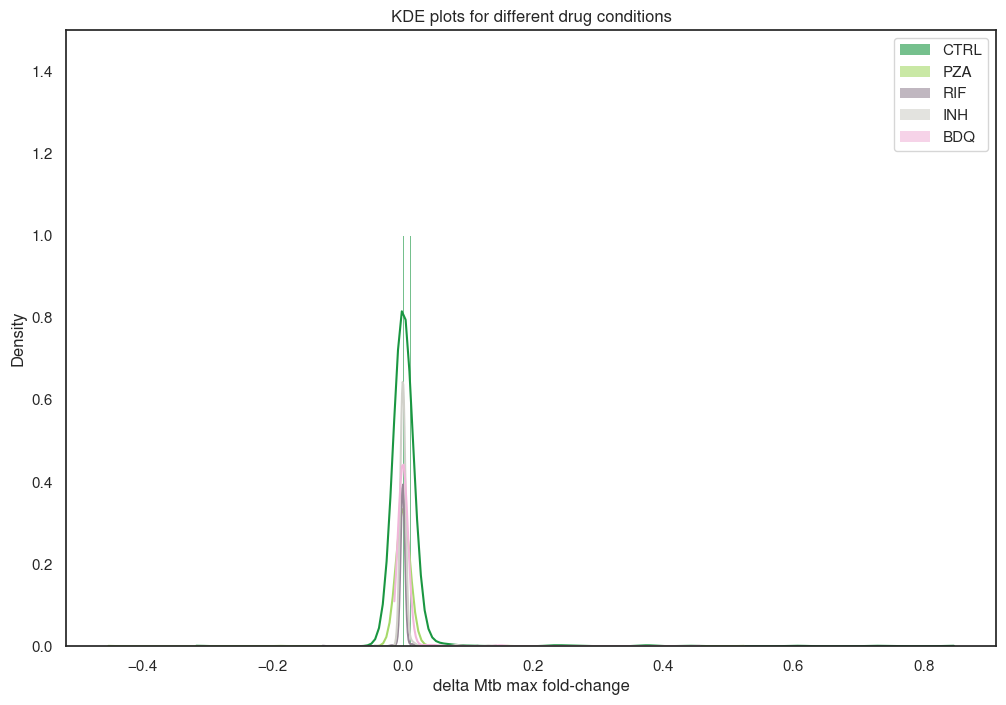

In [442]:
plt.figure(figsize=(12, 8))
for i, compound in enumerate(df_delta_mtb['Compound'].unique()):
    subset = df_delta_mtb[df_delta_mtb['Compound'] == compound]
    sns.histplot(data=subset, x='delta Mtb max fold-change normalised max area', label = compound,
                 kde=True, color=expanded_piyg[i], alpha = 0.6)

plt.xlabel('delta Mtb max fold-change')
plt.ylabel('Density')
plt.title('KDE plots for different drug conditions')
plt.legend()
# plt.xlim(-10000,10000)
plt.ylim(0, 1.50)
plt.show()

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


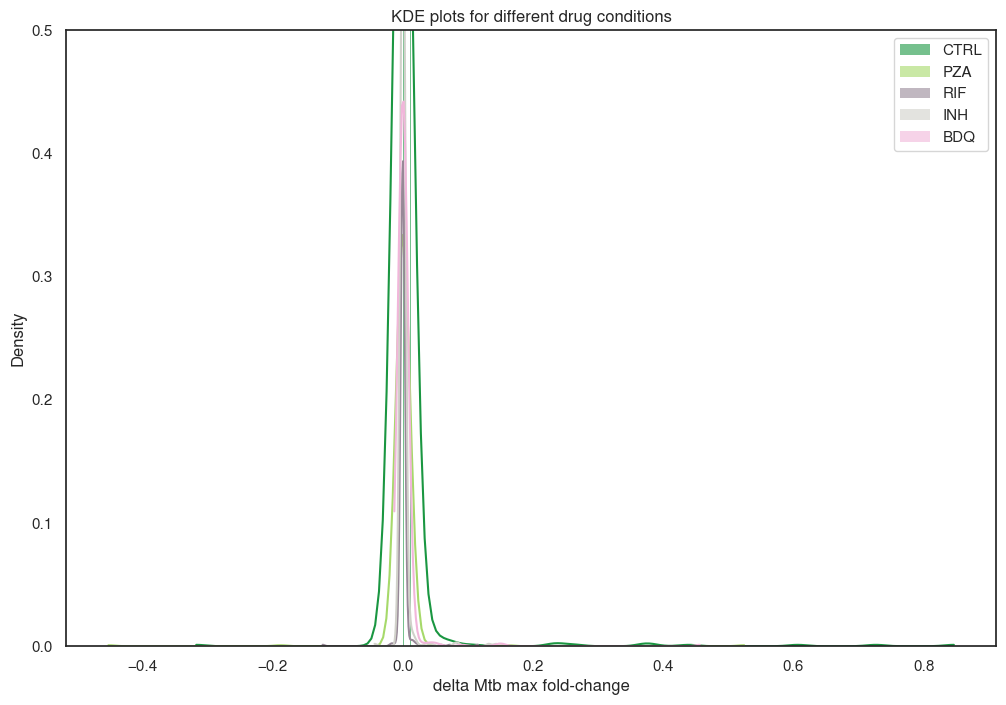

In [443]:
plt.figure(figsize=(12, 8))
for i, compound in enumerate(df_delta_mtb['Compound'].unique()):
    subset = df_delta_mtb[df_delta_mtb['Compound'] == compound]
    sns.histplot(data=subset, x='delta Mtb max fold-change normalised max area', label = compound,
                 kde=True, color=expanded_piyg[i], alpha = 0.6)

plt.xlabel('delta Mtb max fold-change')
plt.ylabel('Density')
plt.title('KDE plots for different drug conditions')
plt.legend()
# plt.xlim(-10000,10000)
plt.ylim(0, 0.5)
plt.show()

# Isolating just the control and ideal ATB case

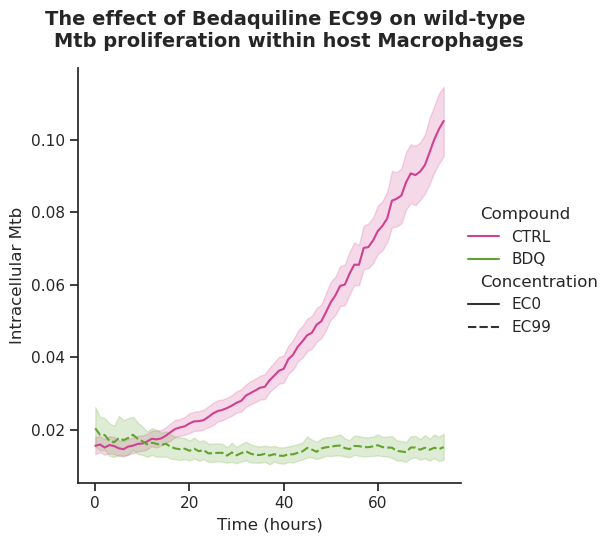

In [60]:
g = sns.relplot(data = df[(df['Strain'] != 'RD1') &
                          (df['Compound'] == 'CTRL') |
                          (df['Compound'] == 'BDQ') &
                          (df['Concentration'] == 'EC99')], 
                        
            x = 'Time (hours)', 
            y = 'Intracellular thresholded Mtb content', 
            style= 'Concentration',
            hue= 'Compound',
#             col= 'Compound',
            kind = 'line',
            aspect = 1,
            palette=[colors[1], colors[-1]]
           )
# # f.set_ylabels("Intracellular $\\mathit{Mtb}$ content")
# g.set_ylabels("Intracellular Mtb content")
g.set_ylabels("Intracellular Mtb")
# # Italicize the "Mtb" portion of the y-axis label using the font manager
# g.ax.yaxis.label.set_fontstyle("italic")
# # plt.rc('text', usetex=False)
plt.gcf().suptitle('The effect of Bedaquiline EC99 on wild-type \nMtb proliferation within host Macrophages', 
                   fontsize=14, fontweight='bold', 
                  y = 1.08)
plt.savefig(os.path.join(output_dir, 'BDQ_CTRL_effect_WT_Mtb.png'), bbox_inches = 'tight', dpi = 314)

## Focusing on BDQ

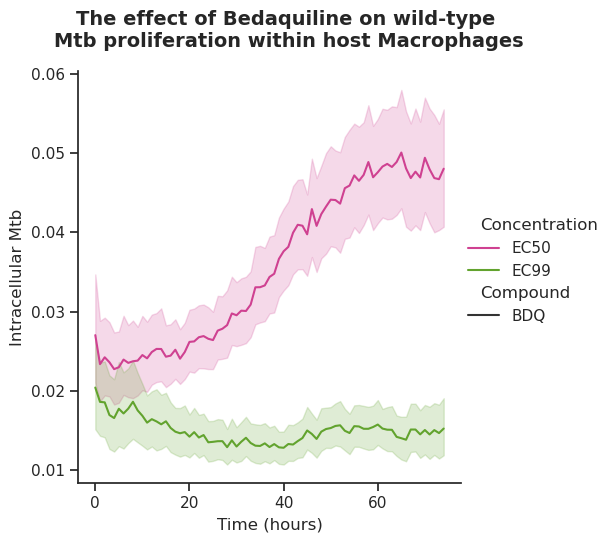

In [61]:
g = sns.relplot(data = df[(df['Compound'] == 'BDQ')
                         ], 
                        
            x = 'Time (hours)', 
            y = 'Intracellular thresholded Mtb content', 
            style= 'Compound',
            hue= 'Concentration',
#             col= 'Compound',
            kind = 'line',
            aspect = 1,
            palette=[colors[1], colors[-1]]
           )
# # f.set_ylabels("Intracellular $\\mathit{Mtb}$ content")
# g.set_ylabels("Intracellular Mtb content")
g.set_ylabels("Intracellular Mtb")
# # Italicize the "Mtb" portion of the y-axis label using the font manager
# g.ax.yaxis.label.set_fontstyle("italic")
# # plt.rc('text', usetex=False)
plt.gcf().suptitle('The effect of Bedaquiline on wild-type \nMtb proliferation within host Macrophages', 
                   fontsize=14, fontweight='bold', 
                  y = 1.08)
plt.savefig(os.path.join(output_dir, 'BDQ_effect_WT_Mtb.png'), bbox_inches = 'tight', dpi = 314)

# Plotting the initial infection status

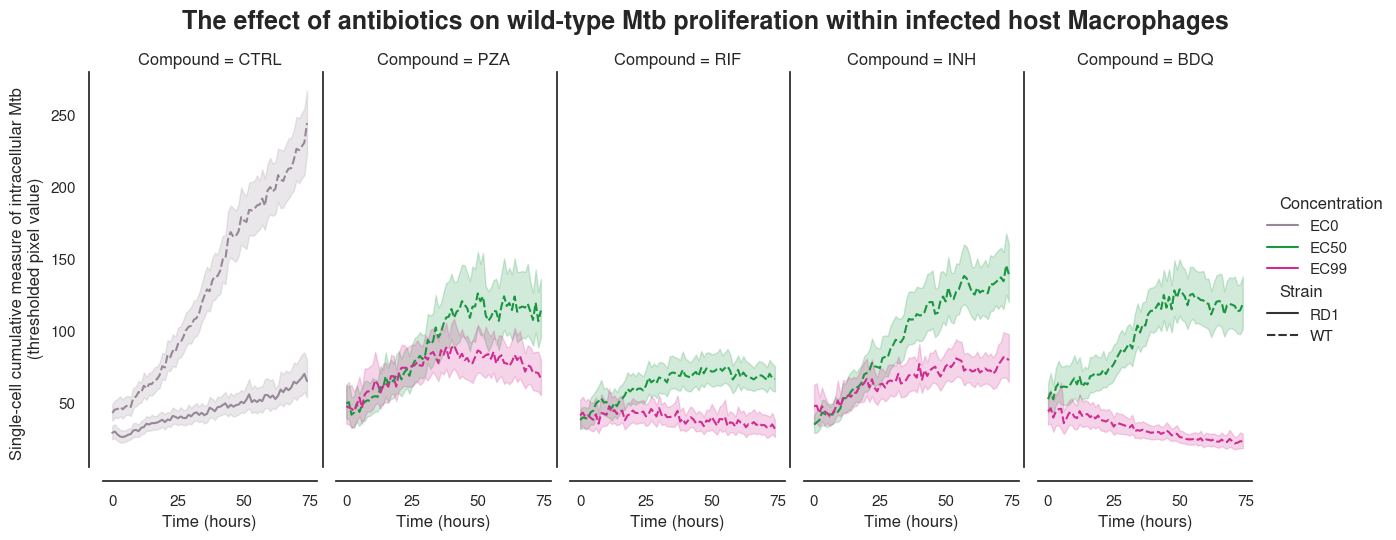

In [80]:
g = sns.relplot(data = df[(df['Infection status'] == 1)], 
            x = 'Time (hours)', 
            y = 'Intracellular thresholded Mtb content', 
            hue = 'Concentration', 
            style= 'Strain',
            col= 'Compound',
            kind = 'line',
            aspect = 0.5,
            palette=[ expanded_piyg[2], expanded_piyg[0],  expanded_piyg[-1],]
           )

g.set_ylabels("Single-cell cumulative measure of intracellular Mtb \n (thresholded pixel value)")
plt.gcf().suptitle('The effect of antibiotics on wild-type Mtb proliferation within infected host Macrophages', 
                   fontsize=18, fontweight='bold', 
                  y = 1.05)
plt.rc('text', usetex=False)
sns.despine(offset=10)
plt.savefig(os.path.join(output_dir, 'ATB_effect_infected_Mtb.png'), bbox_inches = 'tight', dpi = 314)

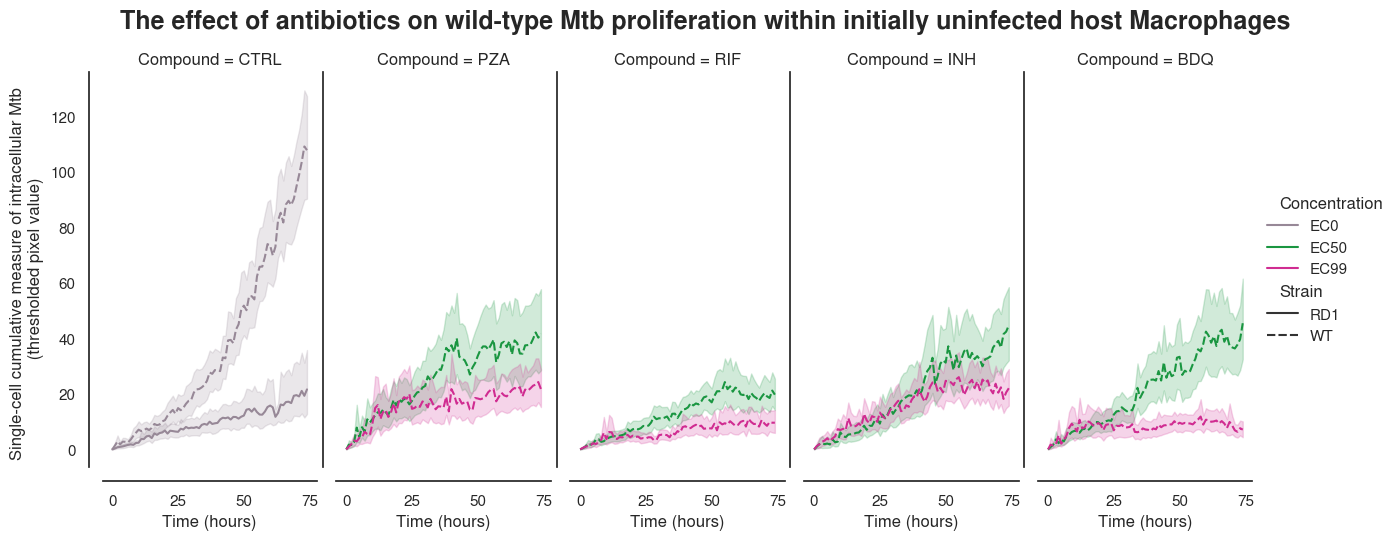

In [81]:
g = sns.relplot(data = df[(df['Initial infection status'] != 1)], 
            x = 'Time (hours)', 
            y = 'Intracellular thresholded Mtb content', 
            hue = 'Concentration', 
            style= 'Strain',
            col= 'Compound',
            kind = 'line',
            aspect = 0.5,
            palette=[ expanded_piyg[2], expanded_piyg[0],  expanded_piyg[-1],]
           )
g.set_ylabels("Single-cell cumulative measure of intracellular Mtb \n (thresholded pixel value)")
plt.gcf().suptitle('The effect of antibiotics on wild-type Mtb proliferation within initially uninfected host Macrophages', 
                   fontsize=18, fontweight='bold', 
                  y = 1.05)
plt.rc('text', usetex=False)
sns.despine(offset=10)
plt.savefig(os.path.join(output_dir, 'ATB_effect_uninfected_Mtb.png'), bbox_inches = 'tight', dpi = 314)

# Finding permissive cells
For each cell with infected status, what is the change in Mtb load?

In [167]:
df

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Macroph. GFP expression,delta Mtb,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID
0,0,404.540741,17.521969,2038.885334,88.310723,1.0,1.0,0.0,22641.0,354.289642,...,1192.025757,-0.027958,0.748962,0.000000,RD1,CTRL,EC0,355,"(3, 4)",355.3.4
1,1,413.055695,10.114442,2081.800701,50.976787,1.0,1.0,0.0,11588.0,350.977905,...,1376.013428,-0.027958,0.645172,11.286093,RD1,CTRL,EC0,355,"(3, 4)",355.3.4
2,2,382.524567,5.971316,1927.923816,30.095434,0.0,1.0,0.0,15089.0,336.285828,...,958.890137,-0.027958,0.964400,30.810960,RD1,CTRL,EC0,355,"(3, 4)",355.3.4
3,3,387.733215,7.013307,1954.175405,35.347068,0.0,1.0,0.0,16723.0,337.263458,...,984.066406,-0.027958,0.948047,5.311851,RD1,CTRL,EC0,355,"(3, 4)",355.3.4
4,4,397.491516,8.356998,2003.357241,42.119272,0.0,1.0,0.0,24029.0,337.026093,...,1016.706482,-0.027958,0.951076,9.850378,RD1,CTRL,EC0,355,"(3, 4)",355.3.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452417,70,740.603149,275.762604,3732.639873,1389.843523,1.0,0.0,0.0,104937.0,363.433960,...,1183.976929,0.000000,0.797845,1.546608,WT,BDQ,EC99,1989,"(6, 9)",1989.6.9
452418,71,742.959290,295.042786,3744.514819,1487.015640,1.0,0.0,0.0,59328.0,360.162720,...,1099.063599,0.000000,0.497413,19.423615,WT,BDQ,EC99,1989,"(6, 9)",1989.6.9
452419,72,743.820374,298.072815,3748.854683,1502.286987,1.0,0.0,0.0,71791.0,365.228577,...,1428.077393,0.000000,0.820148,3.150007,WT,BDQ,EC99,1989,"(6, 9)",1989.6.9
452420,73,744.693665,296.888824,3753.256069,1496.319675,0.0,0.0,0.0,66184.0,358.656128,...,1097.713745,0.000000,0.592617,1.471214,WT,BDQ,EC99,1989,"(6, 9)",1989.6.9


In [168]:
df[df['Acquisition ID'] == (3, 5)]

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Macroph. GFP expression,delta Mtb,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID
17492,0,1008.717163,13.787997,5083.934502,69.491506,0.0,0.0,1.0,16539.0,370.667145,...,2102.166992,0.296730,0.321036,0.000000,WT,CTRL,EC0,328,"(3, 5)",328.3.5
17493,1,1017.692261,13.876625,5129.168994,69.938190,0.0,0.0,1.0,21793.0,366.863525,...,1943.650757,0.296730,0.693013,8.975535,WT,CTRL,EC0,328,"(3, 5)",328.3.5
17494,2,1010.612000,22.133427,5093.484478,111.552470,0.0,0.0,1.0,30076.0,370.363007,...,1980.671875,0.296730,0.856426,10.876804,WT,CTRL,EC0,328,"(3, 5)",328.3.5
17495,3,1017.980957,17.815887,5130.624023,89.792073,0.0,0.0,1.0,38735.0,364.974091,...,1595.770264,0.296730,0.490744,8.540649,WT,CTRL,EC0,328,"(3, 5)",328.3.5
17496,4,1019.862122,18.439526,5140.105093,92.935209,NaN,0.0,1.0,NaN,NaN,...,NaN,0.296730,NaN,1.981844,WT,CTRL,EC0,328,"(3, 5)",328.3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37236,70,322.268707,900.090271,1624.234285,4536.454966,1.0,0.0,1.0,13949.0,384.735260,...,4074.046143,0.013989,0.690332,4.665771,WT,CTRL,EC0,2068,"(3, 5)",2068.3.5
37237,71,324.858215,898.744812,1637.285405,4529.673853,1.0,0.0,1.0,17539.0,390.415070,...,3860.458008,0.013989,0.657098,2.918186,WT,CTRL,EC0,2068,"(3, 5)",2068.3.5
37238,72,323.491119,897.620728,1630.395242,4524.008467,1.0,0.0,1.0,18053.0,388.542084,...,3558.143799,0.013989,0.737329,1.769892,WT,CTRL,EC0,2068,"(3, 5)",2068.3.5
37239,73,320.940338,900.301575,1617.539304,4537.519937,1.0,0.0,1.0,16371.0,386.326538,...,3878.449219,0.013989,0.623358,3.700463,WT,CTRL,EC0,2068,"(3, 5)",2068.3.5


In [174]:
df[(df['delta Mtb'] == 0) & (df['Acquisition ID'] == (3, 5))]

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Macroph. GFP expression,delta Mtb,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID
17862,0,869.708252,51.315140,4383.329590,258.628304,0.0,0.0,0.0,10651.0,365.507935,...,3221.545654,0.0,0.753992,0.000000,WT,CTRL,EC0,314,"(3, 5)",314.3.5
17863,1,869.894836,52.680153,4384.269976,265.507971,0.0,0.0,0.0,10349.0,367.487885,...,3805.524658,0.0,0.473193,1.377706,WT,CTRL,EC0,314,"(3, 5)",314.3.5
17864,2,870.150330,53.819511,4385.557661,271.250338,NaN,0.0,0.0,NaN,NaN,...,NaN,0.0,NaN,1.167653,WT,CTRL,EC0,314,"(3, 5)",314.3.5
17865,3,879.969482,51.205158,4435.046191,258.073997,0.0,0.0,0.0,14162.0,364.665863,...,3020.734619,0.0,0.719241,10.161230,WT,CTRL,EC0,314,"(3, 5)",314.3.5
17866,4,882.416687,55.292709,4447.380103,278.675255,0.0,0.0,0.0,10679.0,368.641449,...,3397.134277,0.0,0.624803,4.764125,WT,CTRL,EC0,314,"(3, 5)",314.3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36989,70,548.385254,1080.732300,2763.861680,5446.890791,0.0,0.0,0.0,79991.0,373.346924,...,2059.243408,0.0,0.795766,1.875342,WT,CTRL,EC0,2023,"(3, 5)",2023.3.5
36990,71,542.582886,1073.401978,2734.617744,5409.945967,1.0,0.0,0.0,96171.0,404.606873,...,2592.448730,0.0,0.584959,9.348856,WT,CTRL,EC0,2023,"(3, 5)",2023.3.5
36991,72,542.676147,1080.964600,2735.087783,5448.061582,0.0,0.0,0.0,72327.0,373.303864,...,2216.799072,0.0,0.775983,7.563197,WT,CTRL,EC0,2023,"(3, 5)",2023.3.5
36992,73,544.904968,1081.448608,2746.321040,5450.500986,0.0,0.0,0.0,72763.0,373.604675,...,2245.941895,0.0,0.775448,2.280769,WT,CTRL,EC0,2023,"(3, 5)",2023.3.5


In [281]:
df_delta_mtb = df_delta_mtb.drop_duplicates()


In [180]:
df[(df['delta Mtb'] < 0) & (df['Acquisition ID'] == (3, 5))]

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Macroph. GFP expression,delta Mtb,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID
17702,0,53.351444,32.730335,268.891279,164.960890,1.0,1.0,0.0,40790.0,345.023102,...,1509.615601,-0.000637,0.891169,0.000000,WT,CTRL,EC0,323,"(3, 5)",323.3.5
17703,1,56.193974,34.384975,283.217627,173.300276,1.0,1.0,0.0,37799.0,347.174042,...,1531.016724,-0.000637,0.900712,3.289043,WT,CTRL,EC0,323,"(3, 5)",323.3.5
17704,2,55.384895,29.955753,279.139872,150.976997,1.0,1.0,0.0,45476.0,345.375885,...,1262.655762,-0.000637,0.872722,4.502512,WT,CTRL,EC0,323,"(3, 5)",323.3.5
17705,3,61.899239,24.086212,311.972162,121.394509,1.0,1.0,0.0,70278.0,344.313843,...,1190.980957,-0.000637,0.751798,8.768591,WT,CTRL,EC0,323,"(3, 5)",323.3.5
17706,4,54.777966,30.044285,276.080946,151.423195,1.0,1.0,0.0,42413.0,346.258698,...,1336.886719,-0.000637,0.872993,9.284996,WT,CTRL,EC0,323,"(3, 5)",323.3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37166,70,453.127197,414.424225,2283.761074,2088.698093,1.0,1.0,0.0,98049.0,363.043701,...,1490.671997,-0.015679,0.853023,0.584299,WT,CTRL,EC0,2092,"(3, 5)",2092.3.5
37167,71,452.274658,412.528046,2279.464277,2079.141350,1.0,1.0,0.0,94502.0,360.016998,...,1360.443848,-0.015679,0.843933,2.079019,WT,CTRL,EC0,2092,"(3, 5)",2092.3.5
37168,72,450.470154,414.157043,2270.369575,2087.351499,1.0,1.0,0.0,102749.0,356.613739,...,1321.010010,-0.015679,0.833678,2.431022,WT,CTRL,EC0,2092,"(3, 5)",2092.3.5
37169,73,450.650635,416.058044,2271.279199,2096.932544,1.0,1.0,0.0,107937.0,356.725128,...,1191.234863,-0.015679,0.832807,1.909549,WT,CTRL,EC0,2092,"(3, 5)",2092.3.5


In [ ]:
plt.hist()

In [ ]:
for cell_ID in set(expt_49['Cell ID'].values):
    mtb_content = expt_49[expt_49['Cell ID'] == cell_ID]['Intracellular Mtb content']
    mean_mtb_content = np.nanmean(mtb_content)
    mtb_range = mtb_content.max() - mtb_content.min()
    expt_49.loc[expt_49['Cell ID'] == cell_ID, 'Mean Mtb content'] = mean_mtb_content
    expt_49.loc[expt_49['Cell ID'] == cell_ID, 'Mtb content range'] = mtb_range

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/seaborn/_core.py:1057: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  comp_col.loc[orig.index] = pd.to_numeric(axis.convert_units(orig))


ValueError: cannot reindex on an axis with duplicate labels

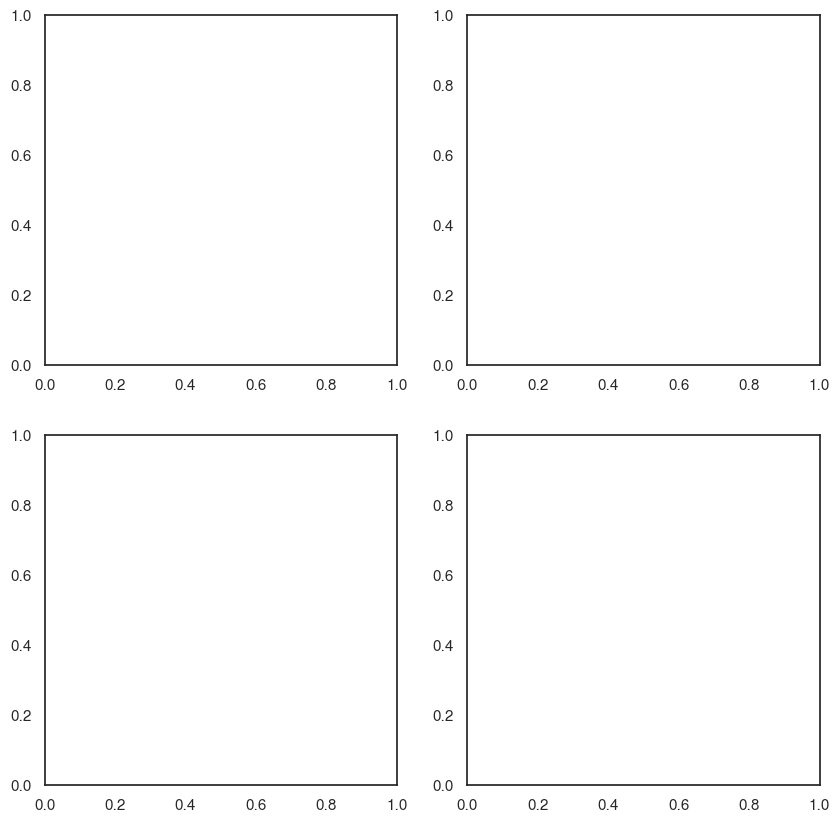

In [289]:
df_delta_mtb_reset = df_delta_mtb.reset_index(drop=True)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

sns.histplot(data=df_delta_mtb, x='delta Mtb raw', kde=False, ax=axes[0, 0])
axes[0, 0].set_title('delta Mtb raw')

sns.histplot(data=df_delta_mtb, x='delta Mtb max raw', kde=False, ax=axes[0, 1])
axes[0, 1].set_title('delta Mtb max raw')

sns.histplot(data=df_delta_mtb, x='delta Mtb max smooth', kde=False, ax=axes[1, 0])
axes[1, 0].set_title('delta Mtb max smooth')

sns.histplot(data=df_delta_mtb, x='delta Mtb max fold-change', kde=False, ax=axes[1, 1])
axes[1, 1].set_title('delta Mtb max fold-change')

plt.tight_layout()
plt.show()


# Adding single-cell measures

Text(0.5, 1.08, 'The effect of Bedaquiline EC50 on wild-type \nMtb proliferation within host Macrophages')

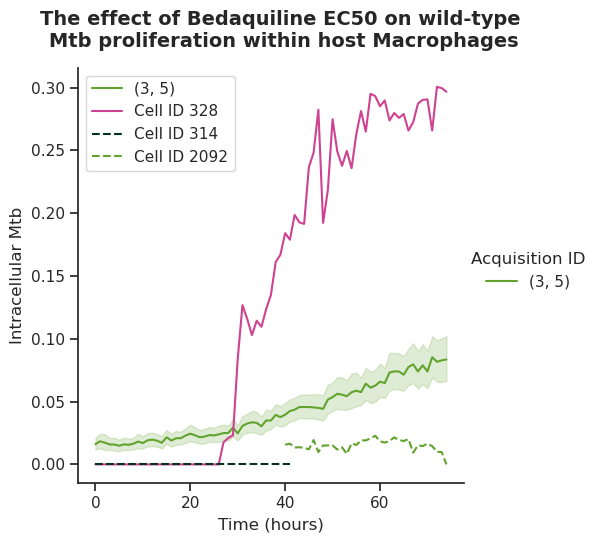

In [183]:
g = sns.relplot(data = df[(df['Acquisition ID'] == (3, 5))], 
            x = 'Time (hours)', 
            y = 'Intracellular thresholded Mtb content', 
            style= 'Acquisition ID',
            hue= 'Acquisition ID',
#             col= 'Compound',
            kind = 'line',
            aspect = 1,

            palette=[colors[-1]],                 
           )
sns.lineplot(x = df[df['Unique ID'] == '328.3.5']['Time (hours)'], 
             y = df[df['Unique ID'] == '328.3.5']['Intracellular thresholded Mtb content'], 
            label = 'Cell ID 328', linestyle='-', color = colors[1])
sns.lineplot(x = df[df['Unique ID'] == '314.3.5']['Time (hours)'], 
             y = df[df['Unique ID'] == '314.3.5']['Intracellular thresholded Mtb content'], 
             label = 'Cell ID 314', linestyle='--', color = colors[0])
sns.lineplot(x = df[df['Unique ID'] == '2092.3.5']['Time (hours)'], 
             y = df[df['Unique ID'] == '2092.3.5']['Intracellular thresholded Mtb content'], 
             label = 'Cell ID 2092', linestyle='--', color = colors[2])
# # f.set_ylabels("Intracellular $\\mathit{Mtb}$ content")
# g.set_ylabels("Intracellular Mtb content")
g.set_ylabels("Intracellular Mtb")
# # Italicize the "Mtb" portion of the y-axis label using the font manager
# g.ax.yaxis.label.set_fontstyle("italic")
# # plt.rc('text', usetex=False)
plt.gcf().suptitle('The effect of Bedaquiline EC50 on wild-type \nMtb proliferation within host Macrophages', 
                   fontsize=14, fontweight='bold', 
                  y = 1.08)
# plt.savefig('/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/april23/BDQ_EC50_effect_WT_Mtb_with_sc_extremes.png', bbox_inches = 'tight', dpi = 314)

Text(0.5, 1.08, 'The effect of Bedaquiline EC50 on wild-type \nMtb proliferation within host Macrophages')

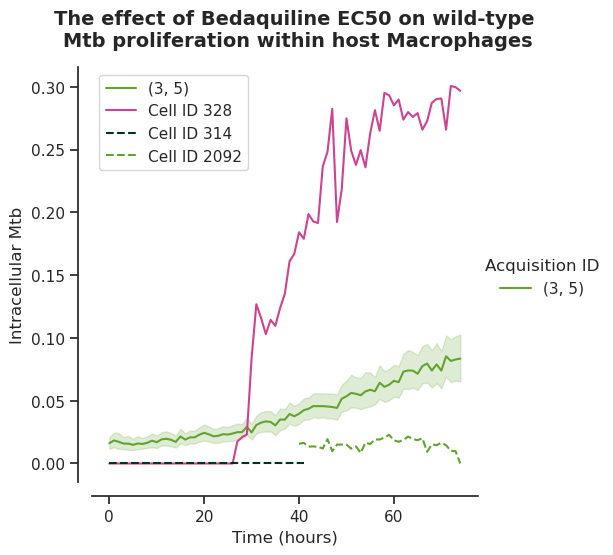

In [184]:
g = sns.relplot(data = df[(df['Acquisition ID'] == (3, 5))], 
            x = 'Time (hours)', 
            y = 'Intracellular thresholded Mtb content', 
            style= 'Acquisition ID',
            hue= 'Acquisition ID',
#             col= 'Compound',
            kind = 'line',
            aspect = 1,

            palette=[colors[-1]],                 
           )
sns.lineplot(x = df[df['Unique ID'] == '328.3.5']['Time (hours)'], 
             y = df[df['Unique ID'] == '328.3.5']['Intracellular thresholded Mtb content'], 
            label = 'Cell ID 328', linestyle='-', color = colors[1])
sns.lineplot(x = df[df['Unique ID'] == '314.3.5']['Time (hours)'], 
             y = df[df['Unique ID'] == '314.3.5']['Intracellular thresholded Mtb content'], 
             label = 'Cell ID 314', linestyle='--', color = colors[0])
sns.lineplot(x = df[df['Unique ID'] == '2092.3.5']['Time (hours)'], 
             y = df[df['Unique ID'] == '2092.3.5']['Intracellular thresholded Mtb content'], 
             label = 'Cell ID 2092', linestyle='--', color = colors[2])
# # f.set_ylabels("Intracellular $\\mathit{Mtb}$ content")
# g.set_ylabels("Intracellular Mtb content")
g.set_ylabels("Intracellular Mtb")
sns.despine(offset=10)
# # Italicize the "Mtb" portion of the y-axis label using the font manager
# g.ax.yaxis.label.set_fontstyle("italic")
# # plt.rc('text', usetex=False)
plt.gcf().suptitle('The effect of Bedaquiline EC50 on wild-type \nMtb proliferation within host Macrophages', 
                   fontsize=14, fontweight='bold', 
                  y = 1.08)
# plt.savefig('/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/april23/BDQ_EC50_effect_WT_Mtb_with_sc_extremes.png', bbox_inches = 'tight', dpi = 314)

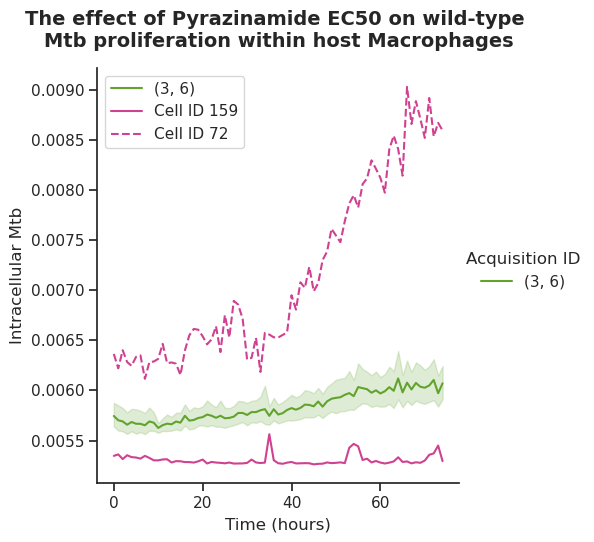

In [194]:
expt = df[(df['Acquisition ID'] == (3, 6))]

g = sns.relplot(data = expt, 
            x = 'Time (hours)', 
            y = 'Intracellular Mtb content', 
            style= 'Acquisition ID',
            hue= 'Acquisition ID',
#             col= 'Compound',
            kind = 'line',
            aspect = 1,
            palette=[colors[-1]],                 
           )

sns.lineplot(x = expt[expt['Cell ID'] == 159]['Time (hours)'], 
             y = expt[expt['Cell ID'] == 159]['Intracellular Mtb content'], 
            label = 'Cell ID 159', linestyle='-', color = colors[1])
sns.lineplot(x = expt[expt['Cell ID'] == 72]['Time (hours)'], 
             y = expt[expt['Cell ID'] == 72]['Intracellular Mtb content'],
             label = 'Cell ID 72', linestyle='--', color = colors[1])
# # f.set_ylabels("Intracellular $\\mathit{Mtb}$ content")
# g.set_ylabels("Intracellular Mtb content")
g.set_ylabels("Intracellular Mtb")
# # Italicize the "Mtb" portion of the y-axis label using the font manager
# g.ax.yaxis.label.set_fontstyle("italic")
# # plt.rc('text', usetex=False)
plt.gcf().suptitle('The effect of Pyrazinamide EC50 on wild-type \nMtb proliferation within host Macrophages', 
                   fontsize=14, fontweight='bold', 
                  y = 1.08)
plt.savefig('/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/april23/PZA_EC50_effect_WT_Mtb_with_sc_extremes.png', bbox_inches = 'tight', dpi = 314)

In [172]:
expt_49[expt_49['Cell ID'] == 17]

,Time (hours),x,y,Area,Intracellular Mtb content,Macroph. GFP expression,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Mean Mtb content,Mtb content range
175359,0,787.419189,841.815674,2376.0,0.005280,0.018034,0.876459,0.000000,WT,BDQ,EC50,17,"(4, 9)",0.005277,0.000148
175360,1,792.964844,841.721985,2248.0,0.005311,0.023384,0.883034,5.546446,WT,BDQ,EC50,17,"(4, 9)",0.005277,0.000148
175361,2,794.169678,845.634888,2487.0,0.005290,0.022281,0.858829,4.094195,WT,BDQ,EC50,17,"(4, 9)",0.005277,0.000148
175362,3,794.383545,844.478271,2902.0,0.005278,0.020764,0.867945,1.176223,WT,BDQ,EC50,17,"(4, 9)",0.005277,0.000148
175363,4,793.184143,845.630737,2911.0,0.005294,0.021835,0.858054,1.663353,WT,BDQ,EC50,17,"(4, 9)",0.005277,0.000148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175429,70,802.580017,847.569946,2967.0,0.005287,0.027800,0.768146,0.856586,WT,BDQ,EC50,17,"(4, 9)",0.005277,0.000148
175430,71,798.543762,851.178406,2685.0,0.005307,0.030774,0.778602,5.414087,WT,BDQ,EC50,17,"(4, 9)",0.005277,0.000148
175431,72,801.885193,850.783386,3379.0,0.005286,0.026049,0.710469,3.364699,WT,BDQ,EC50,17,"(4, 9)",0.005277,0.000148
175432,73,800.708435,854.149414,3286.0,0.005287,0.023522,0.581367,3.565796,WT,BDQ,EC50,17,"(4, 9)",0.005277,0.000148


## Iterating over each expt compound cond

In [159]:
antibiotic_dict = {
    "CTRL": "Control",
    "PZA": "Pyrazinamide",
    "RIF": "Rifampicin",
    "INH": "Isoniazid",
    "BDQ": "Bedaquiline"
}


In [157]:
for (row, col), info in assay_layout.iterrows():
    compound = info['Compound']
    print(compound)

CTRL
CTRL
PZA
RIF
INH
BDQ
CTRL
CTRL
PZA
RIF
INH
BDQ
CTRL
CTRL
PZA
RIF
INH
BDQ
CTRL
CTRL
PZA
RIF
INH
BDQ


In [162]:
for (row, col), info in assay_layout.iterrows():
    compound = info['Compound']
    if compound == 'CTRL':
        continue
    g = sns.relplot(data = df[(df['Compound'] == compound)
                         ], 
            x = 'Time (hours)', 
            y = 'Intracellular Mtb content', 
            style= 'Compound',
            hue= 'Concentration',
#             col= 'Compound',
            kind = 'line',
            aspect = 1,
            palette=[colors[1], colors[-1]]
           )

    g.set_ylabels("Intracellular Mtb")

    plt.gcf().suptitle(f'The effect of {antibiotic_dict[compound]} on wild-type \nMtb proliferation within host Macrophages', 
                       fontsize=14, fontweight='bold', 
                      y = 1.08)
    plt.savefig(f'/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/april23/{compound}_effect_WT_Mtb.png', bbox_inches = 'tight', dpi = 314)
    plt.clf()
    g = sns.relplot(data = df[(df['Compound'] == compound)
                         ], 
                        
            x = 'Time (hours)', 
            y = 'Intracellular Mtb content', 
            style= 'Compound',
            hue= 'Concentration',
#             col= 'Compound',
            kind = 'line',
            aspect = 1,
            palette=[colors[1], colors[-1]]
           )
   
    g.set_ylabels("Intracellular Mtb")
    
    plt.gcf().suptitle(f'The effect of {antibiotic_dict[compound]} on wild-type \nMtb proliferation within host Macrophages', 
                       fontsize=14, fontweight='bold', 
                      y = 1.08)
    plt.savefig(f'/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/april23/{compound}_effect_WT_Mtb.png', bbox_inches = 'tight', dpi = 314)
    plt.clf()
    g = sns.relplot(data = df[(df['Compound'] == compound)
                         ], 
                        
            x = 'Time (hours)', 
            y = 'Intracellular Mtb content', 
            style= 'Acquisition ID',
            hue= 'Concentration',
#             col= 'Compound',
            kind = 'line',
            aspect = 1,
            palette=[colors[1], colors[-1]]
           )
    
    g.set_ylabels("Intracellular Mtb")
   
    plt.gcf().suptitle(f'The effect of {antibiotic_dict[compound]} on wild-type \nMtb proliferation within host Macrophages', 
                       fontsize=14, fontweight='bold', 
                      y = 1.08)
    plt.savefig(f'/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/april23/{compound}_effect_WT_Mtb_separated_by_expt.png', bbox_inches = 'tight', dpi = 314)
    plt.clf()
    g = sns.relplot(data = df[(df['Compound'] == compound) &
                   (df['Concentration'] == 'EC50')
                             ], 

                x = 'Time (hours)', 
                y = 'Intracellular Mtb content', 
                style= 'Acquisition ID',
                hue= 'Acquisition ID',
    #             col= 'Compound',
                kind = 'line',
                aspect = 1,
                palette=[colors[1], colors[-1]]
               )

    g.set_ylabels("Intracellular Mtb")

    plt.gcf().suptitle(f'The effect of {antibiotic_dict[compound]} EC50 on wild-type \nMtb proliferation within host Macrophages', 
                       fontsize=14, fontweight='bold', 
                      y = 1.08)
    plt.savefig(f'/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/april23/{compound}_EC50_effect_WT_Mtb_separated_by_expt.png', bbox_inches = 'tight', dpi = 314)
    plt.clf()

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 642.319x500 with 0 Axes>

<Figure size 626.722x500 with 0 Axes>